# internal wave packet evolution


Spatial decomposition of the vertical velocity field:

$
\begin{align}
w(x, y, t) &= \iint \hat w (k, m) e^{i(kx+mz-\omega t)} dk dm, \\
\omega^2 &= \frac{N^2 k^2 + f^2 m^2}{k^2+m^2}, 
\end{align}
$

At initial time:

$
\begin{align}
w(x, y, 0) &= \iint \hat w (k, m) e^{i(kx+mz)} dk dm, \\
\hat w (k, m) &=  \frac{1}{(2\pi)^2} \iint w (x, z) e^{-i(kx+mz)} dx dz,
\end{align}
$



In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import dashydro.theory as th

### environmental parameters

In [3]:
lat = 43
f = 2 *2*np.pi/86164.1 * np.sin(lat*np.pi/180) # rad/s
N = 1e-3 # rad/s

### physical and spectral domain

In [4]:
Lx, Lz = 40e3, 1e3
dx, dz = 200, 5
ds = xr.Dataset(dict(x=np.arange(-Lx/2,Lx/2,dx),
                     z=np.arange(-Lz/2,Lz/2,dz),
                    ))

#ds = ds.assign_coords(h=-gamma*ds.x)
#xi_p =  mu*ds.x - ds.z
#xi_m = -mu*ds.x - ds.z
#ds["F"] = F(xi_p).where(ds.z+0.*ds.x>-ds.h)
#ds["G"] = G(xi_m).where(ds.z+0.*ds.x>-ds.h)

ds["kx"] = ("kx", np.fft.fftfreq(ds.x.size, d=dx)) # cycles per meters
ds["kz"] = ("kz", np.fft.fftfreq(ds.z.size, d=dz)) # cycles per meters
ds["kappa"] = np.sqrt( ds.kx**2 + ds.kz**2 ) # cycles per meters

ds["omega"] = np.sqrt( (N**2 * ds.kx**2 + f**2 * ds.kz**2) )/ds.kappa
ds["omega"] = ds.omega.fillna(0.)

### initial shape

In [54]:
kz_0 = 2*np.pi/100. # vertical wavenumber
delta_cross = 100. # meters
delta_along = 3e3 # meters
omega_0 = f*1.01
mu =  th.get_mu(omega_0, f, N)
print(f" mu = {mu:.1e}")

 mu = 1.4e-02


In [ ]:
# phase propagation positive in x direction and negative in z direction
# energies is towards positive x and z
xi = mu*ds.x - ds.z 
xi_ortho = ds.x + mu*ds.z

# phase propagation negative in x direction and positive in z direction
# energies is towards negative x and z
#xi = -mu*ds.x + ds.z 
#xi_ortho = ds.x + mu*ds.z

if False:
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    xi.plot.contourf(ax=axes[0], levels=20)
    axes[0].grid()
    xi_ortho.plot.contourf(ax=axes[1], levels=20)
    axes[1].grid()

In [83]:
ds["w_0"] = np.exp(-(xi_ortho/delta_along)**2 - (xi/delta_cross)**2 )*np.exp(1j*kz_0*xi)
ds["w_hat"] = (("kx", "kz"), np.fft.fftn(ds["w_0"]))

Note: this plot is incensitive to propagation direction, e.g. positive/negative x/z direction

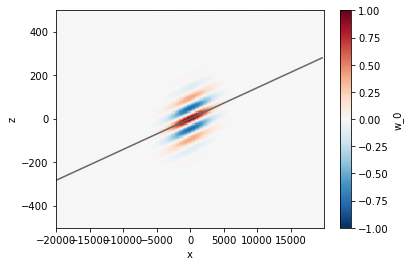

In [78]:
np.real(ds["w_0"]).plot(x="x")
xi.plot.contour(x="x", levels=[0], colors=["0.4"])

### predict evolution at later time

In [79]:
ds["time"] = ("time", np.arange(0, 20, 2/24)) # days
ds["w"] = (("x", "z", "time"), np.real(np.fft.ifftn(ds.w_hat * np.exp(-1j* ds.omega * ds.time * 86400), axes=(0,1))))

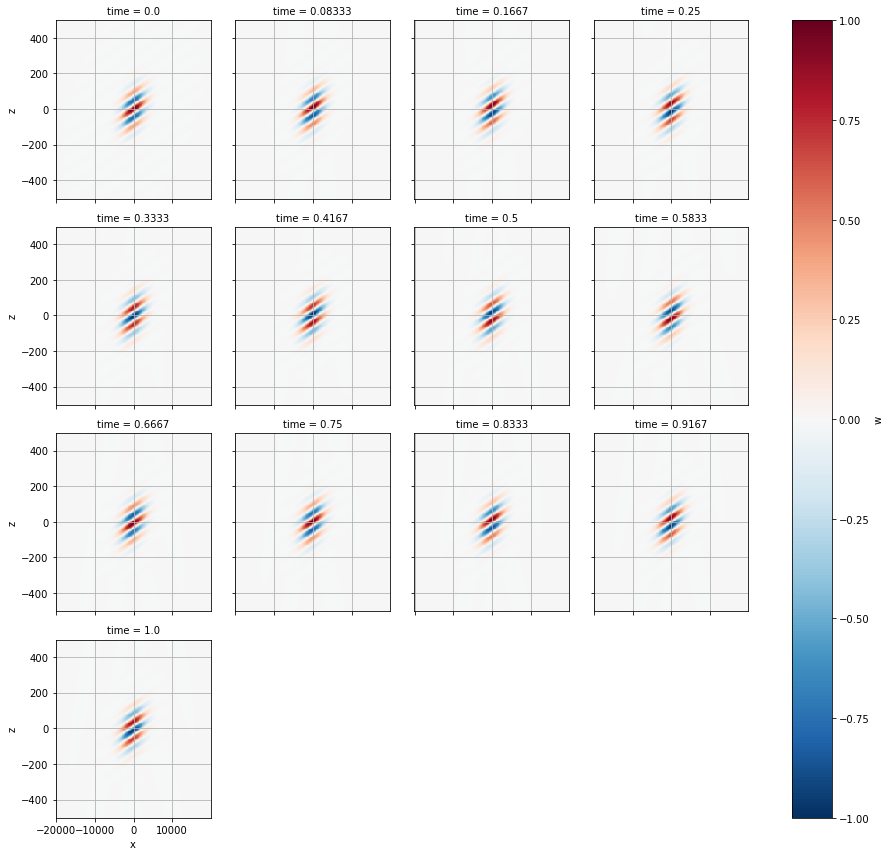

In [80]:
_da = ds.w.sel(time=slice(0,1))
axes = _da.plot(x="x", col="time", col_wrap=4)
for ax in axes.axes.flatten():
    ax.grid()

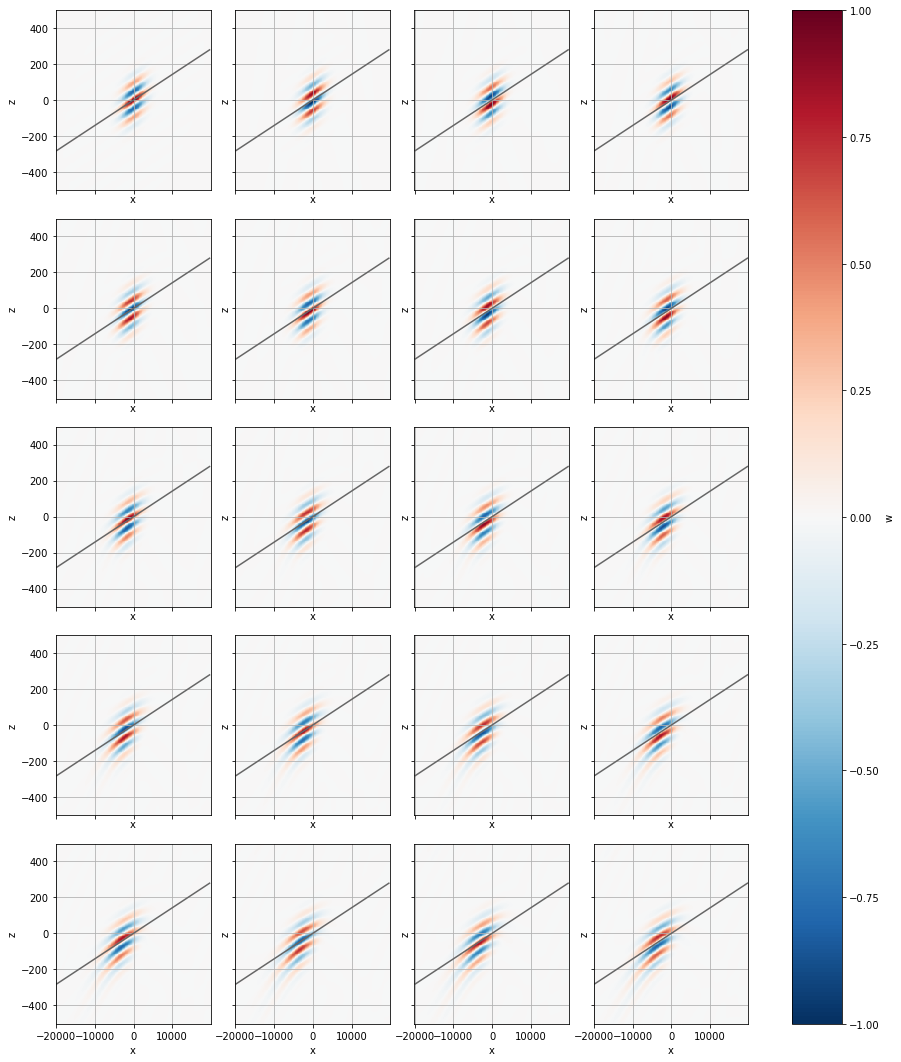

In [81]:
_da = ds.w.isel(time=slice(0,None,12))
axes = _da.plot(x="x", col="time", col_wrap=4)
for ax in axes.axes.flatten():
    ax.grid()
    xi.plot.contour(ax=ax, x="x", levels=[0], colors=["0.4"])

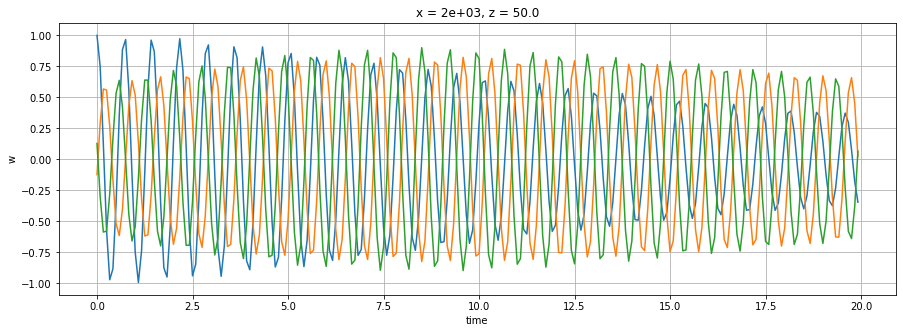

In [62]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
ds.w.sel(z=0, x=0, method="nearest").plot()
ds.w.sel(z=0, x=2e3, method="nearest").plot()
ds.w.sel(z=50, x=2e3, method="nearest").plot()
ax.grid()

---

## with a slopping boundary